In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy as sp

%matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

In [2]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0  = h/(2*e0)

In [3]:
n_eig  = 5
n_plot = 20
param_name = '\\Delta'
param_values = np.geomspace(1e-5, 8, n_plot)
Δ_values = param_values

N_elements = 2
basis_states = [(0,0), (0,1), (1,0), (1,1)]
max_excitations_mediating_states=4
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low = [f'({i},{j})' for i, j in basis_states]
labels_high = [f'({i},{j})' for i, j in mediating_states]

n_eig_extra_low = 2

In [4]:
C, CJ, Csh, Lq, Lr, _, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)
φ_ext=0.5

## Qubit - Cavity 4x4 effective Hamiltonian

In [13]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
ω_f_0      = np.zeros(len(Δ_values))
ω_r_0      = np.zeros(len(Δ_values))
g_r_limit  = np.zeros(len(Δ_values))
g_fq_limit = np.zeros(len(Δ_values))
g_xx_pert  = np.zeros(len(Δ_values), dtype='complex')
g_zz_pert  = np.zeros(len(Δ_values), dtype='complex')
g_yy_pert  = np.zeros(len(Δ_values), dtype='complex')
X          = np.zeros(len(Δ_values), dtype='complex')
E_low_vs_Δ = np.zeros([len(Δ_values),4])


for i, Δ in enumerate(Δ_values):
    C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
    L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
    
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=φ_ext)
    resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ)
    
    H_0, H   = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff, return_H_0=True)
    
    Hf = fluxonium.hamiltonian()
    Hr = resonator.hamiltonian()
    
    ψ0_f         = sq_ext.diag(Hf, n_eig, solver='numpy', real=True)[1]
    ψ0_r         = sq_ext.diag(Hr, n_eig, solver='numpy', real=True)[1]
    
    ψ_0_low = [ qt.tensor(qt.Qobj(ψ0_f[:,i]), qt.Qobj(ψ0_r[:,j]))  for i, j in basis_states]
    ψ_0_high = [ qt.tensor(qt.Qobj(ψ0_f[:,i]), qt.Qobj(ψ0_r[:,j]))  for i, j in mediating_states]
    
    H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0_low, H=H, real=True, remove_ground=True)

    V = H-H_0
    
    E_0_ψ_0_low  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_low]
    E_0_ψ_0_high = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_high]

    H_eff_p2, H_eff_p2_decomposed  =  sq_ext.H_eff_p2_decomposed(ψ_0_low, ψ_0_high, E_0_ψ_0_low, E_0_ψ_0_high, V,  remove_ground=True)

    E_0  = sq_ext.diag(H_0  , n_eig=len(ψ_0_low)+n_eig_extra_low, out='GHz', solver='scipy')[0]
    E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0_low)+n_eig_extra_low, out='GHz', solver='Qutip', qObj=True)
    subspace_indices = sq_ext.find_close_indices(E_0_ψ_0_low,E_0)
    ψ_low = ψ[subspace_indices]
    E_low = E[subspace_indices]
    E_low_vs_Δ[i] = E_low
    
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0_low, ψ_low, E_low, remove_ground=True)
    
    Pauli_p1.append(sq_ext.decomposition_in_pauli_4x4   (H_eff_p1, print_pretty=False))
    Pauli_p2.append(sq_ext.decomposition_in_pauli_4x4   (H_eff_p1+H_eff_p2, print_pretty=False))
    Pauli_SWT.append(sq_ext.decomposition_in_pauli_4x4  (H_eff_SWT, print_pretty=False))
    
    fluxonium.diag(3);
    resonator.diag(3);
    omega_f  = fluxonium.efreqs[1]-fluxonium.efreqs[0]
    omega_f2 = fluxonium.efreqs[2]-fluxonium.efreqs[1]
    omega_r  = resonator.efreqs[1]-resonator.efreqs[0]
       
    Φ_f = fluxonium.flux_op(0, basis='eig')
    Φ_r = resonator.flux_op(0, basis='eig')
    g_xx_pert[i] = 1 / (L_C_eff*nH)  *  (Φ_f[0,1]*Φ_r[0,1]/(2*np.pi*GHz)) 
    # g_zz_pert[i] =   ( (1 / (L_C_eff*nH) )**2   * ( 
    #                 Φ_r[1,2]**2 * Φ_f[0,1]**2/(omega_f+omega_r) +
    #                 Φ_r[0,1]**2 * Φ_f[1,2]**2/(omega_f+omega_r) +
    #                -Φ_r[1,2]**2 * Φ_f[1,2]**2/(omega_f+omega_r) +
    #                 Φ_r[1,2]**2 * Φ_f[0,1]**2/(omega_f-omega_r) +
    #                 Φ_r[0,1]**2 * Φ_f[1,2]**2/(omega_r-omega_f2)  
    #                  )/ (2*np.pi*GHz)**2) / 4
    
    g_zz_pert[i] =   ( (1 / (L_C_eff*nH) )**2   * ( 
                Φ_r[0,1]**2 * Φ_f[1,2]**2*( 1/(omega_r-omega_f2) + 1/(-omega_r-omega_f2) ) 
                 )/ (2*np.pi*GHz)**2) / 4
    # X[i] = +g_zz_pert[i] + g_xx_pert[i]**2 * ((omega_f-omega_r)**-1 + (omega_f+omega_r)**-1)
    X[i] =  -2*g_zz_pert[i] + g_xx_pert[i]**2 * ((omega_f-omega_r)**-1 + (omega_f+omega_r)**-1)
    ω_f_0[i] = omega_f
    ω_r_0[i] = omega_r
    
    # Analytic estimation of coupling
    E_L_f = sq_ext.L_to_EL(L_F_eff)
    V_fluxonium =  lambda φ: E_L_f*φ**2/2 - EJ*GHz*np.cos(φ+np.pi)
    φ_min = sp.optimize.minimize_scalar(V_fluxonium).x
    
    Φ_f_fq_limit_01 = (Φ_0 / (2 * np.pi)) * φ_min / np.sqrt(sq.hbar) 
    Φ_f_r_limit_01  = np.sqrt(0.5*np.sqrt((L_F_eff * nH)/(C_F_eff * fF)))
    Φ_r_01 = np.sqrt(0.5*np.sqrt((L_R_eff * nH)/(C_R_eff * fF)))
    
    g_fq_limit[i] = 1/(L_C_eff * nH) * Φ_f_fq_limit_01 * Φ_r_01  /2 / np.pi / GHz
    g_r_limit[i] =  1/(L_C_eff * nH) * Φ_f_r_limit_01 * Φ_r_01 /2 / np.pi / GHz
    
Pauli_p1  = np.array(Pauli_p1)
Pauli_p2  = np.array(Pauli_p2)
Pauli_SWT = np.array(Pauli_SWT)

# Pauli_p1 = Pauli_p1- Pauli_p1[0,:]
# Pauli_p2 = Pauli_p2- Pauli_p2[0,:]
# Pauli_SWT = Pauli_SWT- Pauli_SWT[0,:]


C:\Users\gabri\AppData\Local\Temp\ipykernel_23220\4126213722.py:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax1.plot(L_C_eff_values[::4]**-1, g_xx_pert[::4] * 1e3, '*', color = colors[0], marker='o', markersize='4')
C:\Users\gabri\AppData\Local\Temp\ipykernel_23220\4126213722.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax1.plot(L_C_eff_values[::4]**-1, g_zz_pert[::4] * 1e3, '*', color = colors[2], marker='o', markersize='4')


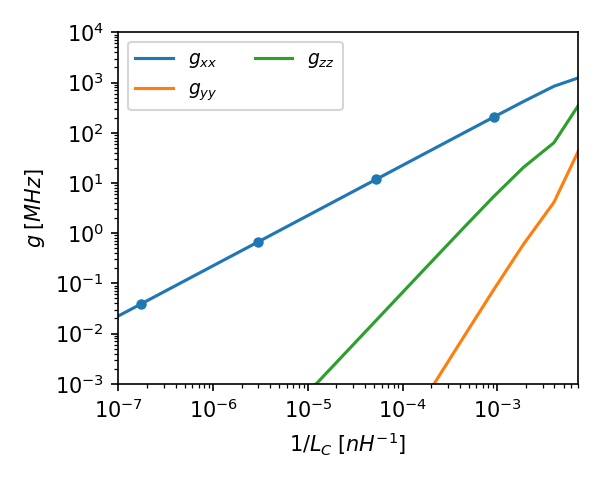

In [14]:
fig, ax1 = plt.subplots(figsize =np.array([5,4])*0.8, dpi=150)
linestyles = ['-', '--','-' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True

L_C_eff_values = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ_values)[-1]

for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==0 or i==2:
    if i==0 or i==1:
        continue

    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])
    ωf = np.abs(Pauli[:, 0,-1])
    ωr = np.abs(Pauli[:, -1,0])

    ax1.plot(L_C_eff_values**-1, σxσx * 1e3, color = colors[0], linestyle=linestyles[i], label = r'$g_{xx}$')
    ax1.plot(L_C_eff_values**-1, σyσy * 1e3, color = colors[1], linestyle=linestyles[i], label = r'$g_{yy}$')
    ax1.plot(L_C_eff_values**-1, σzσz * 1e3, color = colors[2], linestyle=linestyles[i], label = r'$g_{zz}$')

    # ax1.plot(Δ_values, g_fq_limit, 'x', color = colors[0], label = 'g_{xx}, fluxon', markersize='2')
    # ax1.plot(Δ_values, g_r_limit , 's', color = colors[0], label = 'g_{xx}, plasmon', markersize='2')
    ax1.plot(L_C_eff_values[::4]**-1, g_xx_pert[::4] * 1e3, '*', color = colors[0], marker='o', markersize='4')
    ax1.plot(L_C_eff_values[::4]**-1, g_zz_pert[::4] * 1e3, '*', color = colors[2], marker='o', markersize='4')

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-3,1e4])
ax1.set_xlim([1e-7,7e-3])
ax1.set_ylabel('$g \; [MHz]$')
ax1.set_xlabel('$1/L_C \; [nH^{-1}]$')

# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
# figs.export('g_H_eff_vs_Lc.pdf', fig)
fig.show()

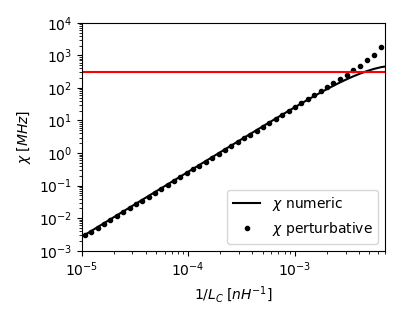

In [289]:
fig, ax = plt.subplots(figsize =np.array([5,4])*0.8, dpi=100)

σzI_q = np.abs(Pauli[:, -1, 0])
Iσz_r = np.abs(Pauli[:, 0,-1])

E_00 = E_low_vs_Δ[:,0]
E_01 = E_low_vs_Δ[:,1]
E_10 = E_low_vs_Δ[:,2]
E_11 = E_low_vs_Δ[:,3]

X_energies = (E_10-E_00) - (E_11-E_01)
# X =  -2*Pauli[:,3,3] + Pauli[:,1,1]**2 * ((ω_f_0-ω_r_0)**-1 + (ω_f_0+ω_r_0)**-1)
# X = Pauli[:,1,1]**2 * ((ω_f_0-ω_r_0)**-1 + (ω_f_0+ω_r_0)**-1)

ax.plot(L_C_eff_values**-1, np.abs(X_energies)*1e3,'k', label='$\chi$ numeric')
ax.plot(L_C_eff_values**-1, np.abs(X)*1e3,'.k', label='$\chi$ perturbative')
# ax.plot(L_C_eff_values**-1, np.abs(X/X_energies),'.k', label='$\chi$, analytic')

# ax.plot(L_C_eff_values**-1, (σzI_q-σzI_q[0]) * 1e3, label='$\sigma_z\otimes I$', color=colors[1])
# ax.plot(L_C_eff_values**-1, (Iσz_r-Iσz_r[0]) * 1e3, label='$I \otimes \sigma_z$', color=colors[1])

# ax.plot(L_C_eff_values**-1, (ω_f_0-ω_f_0[0] - X+X[0]) * 1e3, '.', color=colors[0])

# ax.plot(L_C_eff_values**-1, (omega_r-omega_r[0]) * 1e3, label='$\omega_+$', color=colors[1])
# ax.plot(L_C_eff_values**-1, (ω_r_0-ω_r_0[0] -X/2 +X[0]/2) * 1e3 , '.', color=colors[1])


# ax.plot(L_C_eff_values**-1, (omega_r- omega_f) * 1e3 , '.', color=colors[1])

ax.hlines(300, 1e-5,7e-3, 'r')


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e-3,1e4])
ax.set_xlim([1e-5,7e-3])
ax.set_ylabel('$\chi\; [MHz]$')
ax.set_xlabel('$1/L_C \; [nH^{-1}]$')
ax.legend(loc=4)

fig.tight_layout()
figs.export('chi_vs_Lc.pdf', fig)
fig.show()

In [274]:
X/X_energies

array([1.090149604424, 0.971146358809, 0.969959972410, 0.969835861174, 0.969830521907, 0.969838487544, 0.970005972224, 0.973440402758, 1.044547304477, -0.478992256091])

C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:1750: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize, dpi=150)
C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


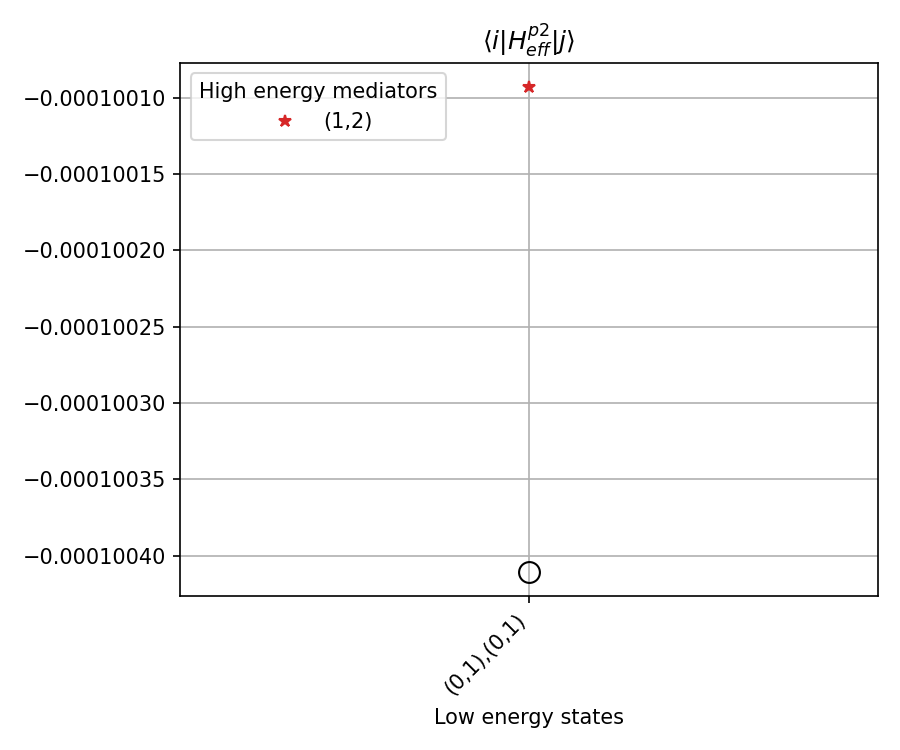

In [38]:
sq_ext.plot_second_order_contributions(H_eff_p2_decomposed, labels_low, labels_high,figsize=np.array([6, 5]) * 1 ,threshold =1e-4)

## Qubit 2x2 effective Hamiltonian

In [139]:
N_elements = 2
basis_states = [(0,0),(1,0)]
max_excitations_mediating_states=3
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low = [f'({i},{j})' for i, j in basis_states]
labels_high = [f'({i},{j})' for i, j in mediating_states]

n_eig_extra_low = 2

In [140]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
g_z_pert   = np.zeros(len(Δ_values))
E_low_vs_Δ = np.zeros([len(Δ_values),2])

for i, Δ in enumerate(Δ_values):
    C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
    L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
    
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=φ_ext )
    resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ )
    
    H_0, H   = sq_ext.hamiltonian_qubit(Lq=L_F_eff, Lr=Lr, fluxonium = fluxonium, resonator = resonator, Δ=Δ, return_H_0=True)
    
    Hf = fluxonium.hamiltonian()
    Hr = resonator.hamiltonian()
    
    ψ0_f         = sq_ext.diag(Hf, n_eig, solver='numpy', real=True)[1]
    ψ0_r         = sq_ext.diag(Hr, n_eig, solver='numpy', real=True)[1]
    
    ψ_0_low = [ qt.tensor(qt.Qobj(ψ0_f[:,i]), qt.Qobj(ψ0_r[:,j]))  for i, j in basis_states]
    ψ_0_high = [ qt.tensor(qt.Qobj(ψ0_f[:,i]), qt.Qobj(ψ0_r[:,j]))  for i, j in mediating_states]
    
    H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0_low, H=H, real=True, remove_ground=True)
       
    V = H-H_0
    
    E_0_ψ_0_low  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_low]
    E_0_ψ_0_high = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_high]

    H_eff_p2, H_eff_p2_decomposed  =  sq_ext.H_eff_p2_decomposed(ψ_0_low, ψ_0_high, E_0_ψ_0_low, E_0_ψ_0_high, V,  remove_ground=True)

    E_0  = sq_ext.diag(H_0  , n_eig=len(ψ_0_low)+n_eig_extra_low, out='GHz', solver='scipy')[0]
    E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0_low)+n_eig_extra_low, out='GHz', solver='Qutip', qObj=True)
    subspace_indices = sq_ext.find_close_indices(E_0_ψ_0_low,E_0)
    ψ_low = ψ[subspace_indices]
    E_low = E[subspace_indices]
    E_low_vs_Δ[i] = E_low
    
    
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0_low, ψ_low, E_low, remove_ground=True)
    
    Pauli_p1.append( sq_ext.decomposition_in_pauli_2x2   (H_eff_p1 ))
    Pauli_p2.append( sq_ext.decomposition_in_pauli_2x2   (H_eff_p1+H_eff_p2 ))
    Pauli_SWT.append(sq_ext.decomposition_in_pauli_2x2  (H_eff_SWT ))
    
    fluxonium.diag(3);
    resonator.diag(3);
    omega_f  = fluxonium.efreqs[1]-fluxonium.efreqs[0]
    omega_f2 = fluxonium.efreqs[2]-fluxonium.efreqs[1]
    omega_r  = resonator.efreqs[1]-resonator.efreqs[0]
    
    g_z_pert[i] = 1/2 * g_xx_pert[i]**2 * ( 1/(omega_f+omega_r) + 1/(omega_f-omega_r) + 1/(omega_f-omega_r-omega_f2) ) * 1/2
    # g_z_pert[i] = 1/2 * g_xx_pert[i]**2 * ( 1/(omega_f+omega_r) + 1/(omega_f-omega_r)  ) * 1/2
    # g_z_pert[i] = 1/2 * g_xx_pert[i]**2 * ( 1/(omega_f+omega_r)  + 1/(omega_f-omega_r-omega_f2) ) * 1/2
    # g_z_pert[i] = 1/2 * g_xx_pert[i]**2 * (1/(omega_f-omega_r) + 1/(omega_f-omega_r-omega_f2) ) * 1/2
    
Pauli_p1 = np.array(Pauli_p1)
Pauli_p1 = Pauli_p1- Pauli_p1[0,:]

Pauli_p2 = np.array(Pauli_p2)
Pauli_p2 = Pauli_p2- Pauli_p2[0,:]

Pauli_SWT = np.array(Pauli_SWT)
Pauli_SWT = Pauli_SWT- Pauli_SWT[0,:]

C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:1864: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i] = 0.5 * np.trace(s[i].T.conjugate() @ A)


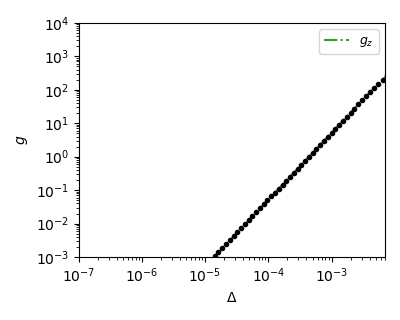

In [143]:
fig, ax1 = plt.subplots(figsize =np.array([5,4])*0.8, dpi=100)
linestyles = ['-', '--','-.' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True

ω_q = E_low_vs_Δ[:,1]-E_low_vs_Δ[:,0]
ω_q-=ω_q[0]

for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==1 or i==2:
    if i==0 or i==1:
        continue

    σx = np.abs(Pauli[:, 1])
    σy = np.abs(Pauli[:, 2])
    σz = np.abs(Pauli[:, 3])

    # ax1.plot(L_C_eff_values**-1, σx*1e3, color = colors[0], linestyle=linestyles[i], label = r'$g_{x}$')
    # ax1.plot(L_C_eff_values**-1, σy*1e3, color = colors[1], linestyle=linestyles[i], label = r'$g_{y}$')
    ax1.plot(L_C_eff_values**-1, σz*1e3, color = colors[2], linestyle=linestyles[i], label = r'$g_{z}$')

    # ax1.plot(Δ_values, g_x_pert , '*', color = colors[0], marker='o', markersize='4')
    # ax1.plot(L_C_eff_values**-1, np.abs(g_z_pert)*1e3 , '*', color = colors[2], marker='o', markersize='4')
    # ax1.plot(Δ_values, np.abs(g_zz_pert) , '*', color = colors[2], marker='o', markersize='4')
    # ax1.plot(Δ_values, g_yy_pert , '*', color = colors[1],  markersize='4')
    
    ax1.plot(L_C_eff_values**-1, (ω_q/2)*1e3, '.k')

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)
 
ax1.set_yscale('log')
ax1.set_xscale('log')
# ax1.set_ylim([1e-7,1e-3])
# ax1.set_xlim([1e-3,1e-1])
# ax1.set_xlim(left=1e-1)

ax1.set_ylim([1e-3,1e4])
ax1.set_xlim([1e-7,7e-3])
ax1.set_ylabel('$g$')
ax1.set_xlabel('$\Delta$')



# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
# figs.export('g_H_eff_vs_Delta.pdf', fig)
fig.show()

In [144]:
(ω_q/2)*1e3

array([0.000000000000, 0.000000000148, 0.000000000344, 0.000000000616, 0.000000001012, 0.000000001438, 0.000000002073, 0.000000002886, 0.000000004007, 0.000000005428, 0.000000007318, 0.000000009771, 0.000000013077, 0.000000017299, 0.000000022997, 0.000000030430, 0.000000040164, 0.000000053060,
       0.000000070020, 0.000000092291, 0.000000121655, 0.000000160206, 0.000000211008, 0.000000277841, 0.000000365793, 0.000000481569, 0.000000633913, 0.000000834365, 0.000001098185, 0.000001445430, 0.000001902271, 0.000002503562, 0.000003294861, 0.000004336180, 0.000005706558, 0.000007510027,
       0.000009883294, 0.000013006585, 0.000017116711, 0.000022525681, 0.000029643834, 0.000039011323, 0.000051338869, 0.000067561926, 0.000088911358, 0.000117007091, 0.000153980932, 0.000202638359, 0.000266671343, 0.000350938385, 0.000461833480, 0.000607770942, 0.000799823876, 0.001052564737,
       0.001385170594, 0.001822878485, 0.002398900210, 0.003156942449, 0.004154523074, 0.005467335663, 0.0071949926

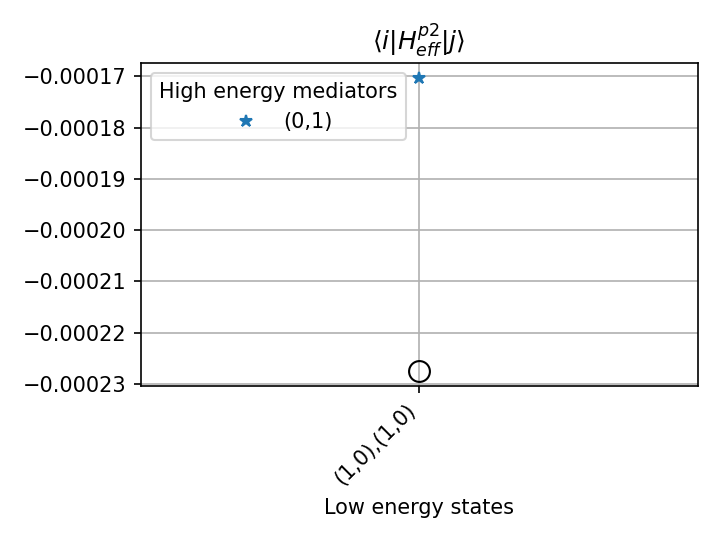

In [54]:
sq_ext.plot_second_order_contributions(H_eff_p2_decomposed, labels_low, labels_high,figsize=np.array([4,3]) * 1.2 ,threshold =1e-4)